In [1]:
import sys
sys.path.append('../')  # Adds the parent directory to the Python path

In [2]:
from __future__ import annotations
#from pyrsistent import m
from torch.utils.data import Dataset
from intern import array
import numpy as np
import os
import json
import torch
from os.path import exists
from requests.exceptions import HTTPError
from torchvision import transforms
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import warnings
import matplotlib.pyplot as plt 
from scripts.loading_model import load_model
from scripts.load_pretrained_weights import load_weights

/Users/latchtd1/Documents/bossdb_cookbook/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Custom BossDB Dataset classes for Pytorch DataLoaders

In this notebook we provide some example custom Dataset classes for use with Pytorch DataLoaders. Please see https://pytorch.org/tutorials/beginner/basics/data_tutorial.html  and https://pytorch.org/tutorials/beginner/data_loading_tutorial.html for additional information. These classes can easily be adapted for your specific needs.


## 1. Dataset class - 3D image volumes and corresponding segmentation masks from the data 

In [3]:
from scripts.bossdbdataset import BossDBDataset 

## 2. Choosing a Dataset
To use this notebook with a different dataset from BossDB:

1. **Explore BossDB Projects**: Visit the [BossDB Projects page](https://bossdb.org/projects) to view all available public datasets.
2. **Select a Dataset**: Choose a dataset that fits your research needs. For this demonstration, we use the Kasthuri dataset as an example.
3. **Understand Data Types**: EM data typically consists of grayscale images (`uint8` format, 0-255 range), and segmentation data uses 64-bit integers for dense labeling.
4. **Construct the URI**: Use the format `bossdb://{Collection}/{Experiment}/{Channel}` to create the URI for your dataset. For the Kasthuri dataset, the URIs would be `bossdb://Kasthuri/ac4/em` for EM data and `bossdb://Kasthuri/ac4/neuron` for neuron segmentation.


### Data Type Specifications
Our model has been tested with the following data types:
- **EM Data**: `uint8` format is expected for EM data channels.
- **Annotation Channels**: `uint8` format is used for binary mask annotations. We support both binary masks (for membranes) and dense segmentation maps (for synapses, where each has a unique label).


### Task Configuration Instructions:

To adapt this notebook for your specific dataset, configure the `task_config` dictionary as follows:

- **`name`**: Assign a meaningful name to your task. This helps identify different tasks or models when saving or loading data.
  
- **`image_chan`**: Specify the URI for the image data channel from your selected BossDB dataset. Use the format `bossdb://{Collection}/{Experiment}/em`.
  
- **`annotation_chan`**: Specify the URI for the annotation data channel. Use the format `bossdb://{Collection}/{Experiment}/annotation_channel`.

- **`xrange_vol`**: Set the range of values along the X-axis for the volume of interest from your dataset.
  
- **`yrange_vol`**: Set the range of values along the Y-axis for the volume of interest.

- **`z_train`**: Define the range of slices along the Z-axis for the training set. Adjust this according to the slices you intend to use for training. If not training a model, default z-range is specified by `z_train` value.
  
- **`z_val`**: Define the range of slices along the Z-axis for the validation set. Adjust this according to the slices you intend to use for validation. If not training a model, only use `z_train` to specify z-range.

- **`z_test`**: Define the range of slices along the Z-axis for the testing set. Adjust this according to the slices you intend to use for testing. If not training a model, only use `z_train` to specify z-range.

- **`volume_z`**: Indicate the depth or thickness of each slice along the Z-axis. This is important for 3D datasets.

- **`tile_size`**: Specify the size of each tile or chunk of data. This should be in the format `[width, height]`.

- **`threshold`**: If you need to apply thresholding to your annotation data, set this to `True` and provide a `threshold_value`.

Below is a template you can start with:

```python
task_config = {
    "name": "your_task_name",  # Replace with a name for your task
    "image_chan": "bossdb://{Collection}/{Experiment}/em",  # Replace with your EM channel URI
    "annotation_chan": "bossdb://{Collection}/{Experiment}/annotation_channel",  # Replace with your annotation channel URI
    "xrange_vol": [your_start_x, your_end_x],  # Replace with your X-range
    "yrange_vol": [your_start_y, your_end_y],  # Replace with your Y-range
    "z_train": [your_start_z_train, your_end_z_train],  # Replace with your Z-range for training
    "z_val": [your_start_z_val, your_end_z_val],  # Replace with your Z-range for validation
    "z_test": [your_start_z_test, your_end_z_test],  # Replace with your Z-range for testing
    "volume_z": your_volume_thickness,  # Replace with your volume thickness
    "tile_size": [your_tile_width, your_tile_height],  # Replace with your tile size
    "threshold": False  # Set to True if thresholding is needed
}


In [4]:
# Configuration Python dictionary
task_config = {
    "name": "membrane_task", #specify name according to task
    "image_chan": "bossdb://Kasthuri/ac4/em", # image slices
    "annotation_chan": "bossdb://Kasthuri/ac4/membrane", # annotations (for synapses, use "bossdb://Kasthuri/ac4/membrane")
    "xrange_vol": [10, 522], # adjust x-range
    "yrange_vol": [12, 524], # adjust y-range
    "z_train": [0, 80], # adjust z-range
    "z_val": [80, 90],    
    "z_test": [90, 100],
    "volume_z": 1,
    "tile_size": [256,256],
    "task_type" : "membrane",
    "threshold": False
}

## 3. Creating the Datasets

Using the defined task configuration to create datasets.


In [5]:
# Create the dataset
dataset = BossDBDataset(task_config)

/Users/latchtd1/Documents/bossdb_cookbook/.venv/lib/python3.11/site-packages/intern/convenience/array.py:922: ImportWarning: CloudVolume is not installed. Accessing channel using CVDB.
  warnings.warn(


## 4. Fetching and Visualizing Images/Masks

With the datasets created, we can fetch specific slices of data and visualize them. For this demonstration, we'll fetch a sample from the membrane dataset.

In [6]:
# Fetch the first sample from the dataset
image, mask = dataset[0]

# Similarly, you can fetch samples from the synapse dataset

/Users/latchtd1/Documents/bossdb_cookbook/notebooks/../scripts/bossdbdataset.py:219: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  image = torch.FloatTensor(image_array) / 255.


In [7]:
#Data Characteristics
print(f'Shape of input: {image.shape}')
print(f'Shape of groundtruth annotations: {mask.shape}')

Shape of input: torch.Size([1, 256, 256])
Shape of groundtruth annotations: torch.Size([256, 256])


After fetching the data slices, it's essential to visualize them to ensure the correctness of the fetched data and to gain insights. We'll use the `visualize_image_mask` function to display the image and its corresponding mask side by side.

### Function Definition

The `visualize_image_mask` function takes in two arguments: the image tensor and the mask tensor. It then visualizes them side by side using matplotlib.

- **Input Tensors:** The function accepts two tensors - the image and the mask. Both tensors are expected to be 2D (height x width) or 3D (channels x height x width). If a channel dimension exists and is of size 1, it gets squeezed out for visualization.
- **Visualization:** The function uses matplotlib to display the image and mask side by side. The image is displayed using a grayscale colormap.
- **Layout:** The visualizations are displayed without axis ticks for clarity, and the titles "Image" and "Mask" are used to label the respective visualizations.

In [8]:
def visualize_image_mask(image, mask):
    """
    Visualize the image and mask side by side.
    
    Args:
        image (torch.Tensor): The image tensor.
        mask (torch.Tensor): The mask tensor.
        slice_idx (int, optional): The index of the slice to visualize. If None, the middle slice is used.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    # If the image has a channel dimension, remove it
    if len(image.shape) == 3 and image.shape[0] == 1:
        image = image.squeeze(0)
    if len(mask.shape) == 3 and mask.shape[0] == 1:
        mask = mask.squeeze(0)
    
    ax1.imshow(image, cmap='gray')
    ax1.set_title('Image')
    ax1.axis('off')
    
    ax2.imshow(mask)
    ax2.set_title('Mask')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()


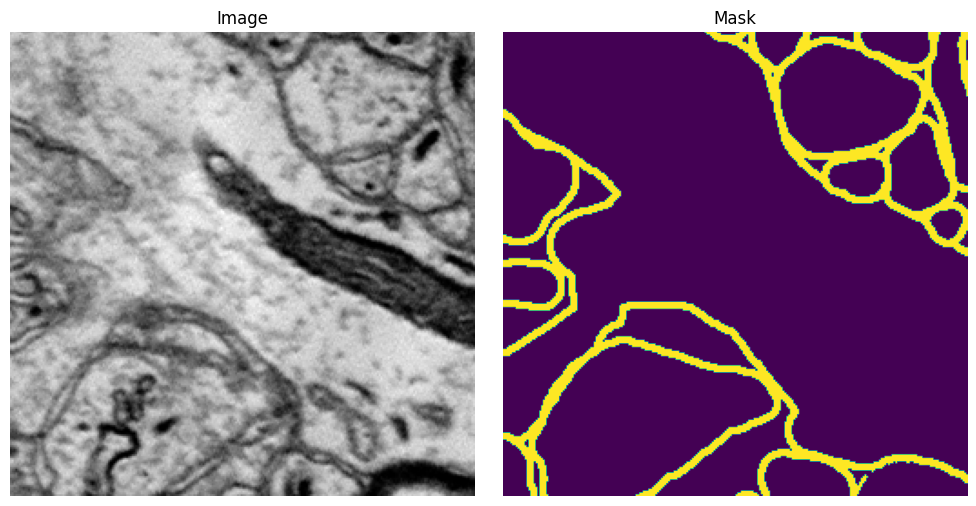

In [9]:
# Visualize the image and mask
visualize_image_mask(image, mask)

## 5. Inferencing with Model

### Download Model Weights

If you need to download model weights, uncomment out the command below and run. (Make sure you have AWS CLI installed)

In [10]:
# !aws s3 cp --recursive --no-sign-request s3://bossdb-datalake/public/kasthuri-challenge-pretrained-weights/ ./pretrained_model_weights/

### Setup and Configuration 
First, ensure you've set up the necessary network configurations and loaded the appropriate model weights.

In [11]:
# Choose a model type by uncommenting the desired model line and commenting out the others.
model_type = "unet"          # Default model type is set to "unet"
# model_type = "depth"       # Uncomment this line to choose the "depth" model
# model_type = "residual"    # Uncomment this line to choose the "residual" model
# model_type = "attention"   # Uncomment this line to choose the "attention" model

root = "../"

task = "membrane"
dimensions = 2  # mode

# Load the appropriate network configurations JSON files
if model_type == "unet":
    with open(os.path.join(root, f"networkconfig/UNet_{dimensions}D.json")) as file:
        network_config = json.load(file)
else:
    with open(os.path.join(root, f"networkconfig/UNet_{dimensions}D_{model_type}.json")) as file:
        network_config = json.load(file)

### Load Model

In [12]:
# Specify device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Initialize the model
model_object = load_model(network_config, device)

loading UNet model


### Load Weights

In [13]:
model_object = load_weights(model_type, task, model_object)

Successfully loaded pre-trained weights into the unet Model


### Prediction

In [14]:
# Function to predict using trained model
def predict(img, model, device):
    model.eval()
    x = img.to(device)  # to torch, send to device
    with torch.no_grad():
        out = model(x)  # send through model/network

    out_argmax = torch.argmax(out, dim=1)  # perform softmax on outputs
    return out_argmax

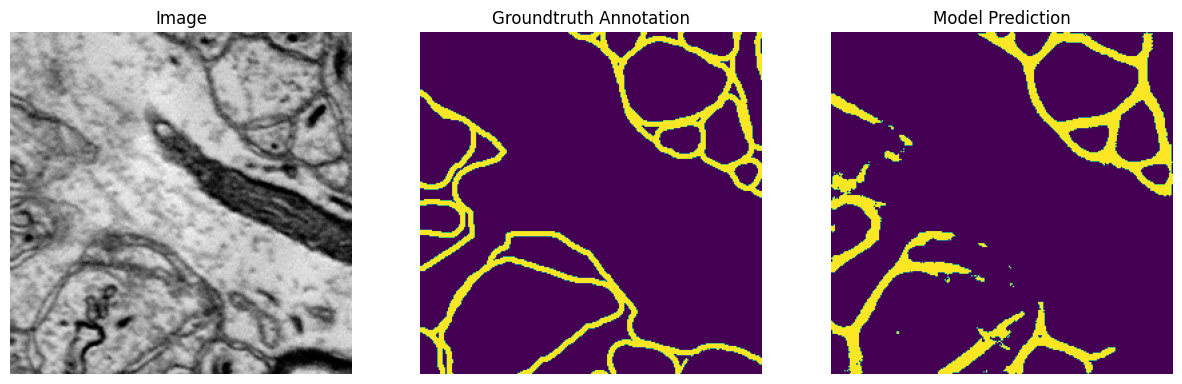

In [15]:
# Add a batch dimension to the image and mask
x = image.unsqueeze(0)
y = mask.unsqueeze(0)
target = y.to(device) 

# Segment the input image with the model
output = predict(x, model_object, device)

# Visualization
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
ax1.imshow(x.squeeze().cpu().numpy(), cmap='gray')
ax1.title.set_text("Image")
ax1.axis('off')

ax2.imshow(y.squeeze().cpu().numpy())  
ax2.title.set_text("Groundtruth Annotation")
ax2.axis('off')

ax3.imshow(output.cpu().squeeze().numpy()) 
ax3.title.set_text("Model Prediction")
ax3.axis('off')

plt.show()